## Project Overview: Building an Intelligent Loan Approval Prediction System

 Let's import our required libraries:

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


### Exploratory Data Analysis

In [ ]:
# Load the dataset
loan_df = pd.read_csv('loan_data.csv')

loan_df.head()

In [15]:
# Display the number of rows and columns in the dataset
print("Number of rows and columns:", loan_df.shape)

# Display summary statistics for numerical variables
print(loan_df.describe())

Number of rows and columns: (9578, 14)
       credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days.with.cr.line     revol.bal   revol.util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.3756

In [19]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [16]:
# Check for missing values
print(loan_df.isnull().sum())

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64


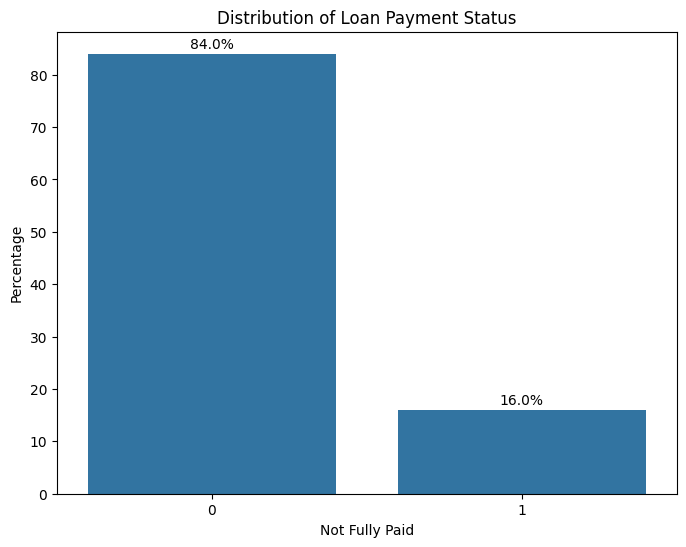

In [20]:
# Let's calculate and plot class distribution with percentages
plt.figure(figsize=(8, 6))
class_counts = loan_df['not.fully.paid'].value_counts()
class_percentages = (class_counts / len(loan_df)) * 100

sns.barplot(x=class_counts.index, y=class_percentages)
plt.title('Distribution of Loan Payment Status')
plt.xlabel('Not Fully Paid')
plt.ylabel('Percentage')
for i, v in enumerate(class_percentages):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()

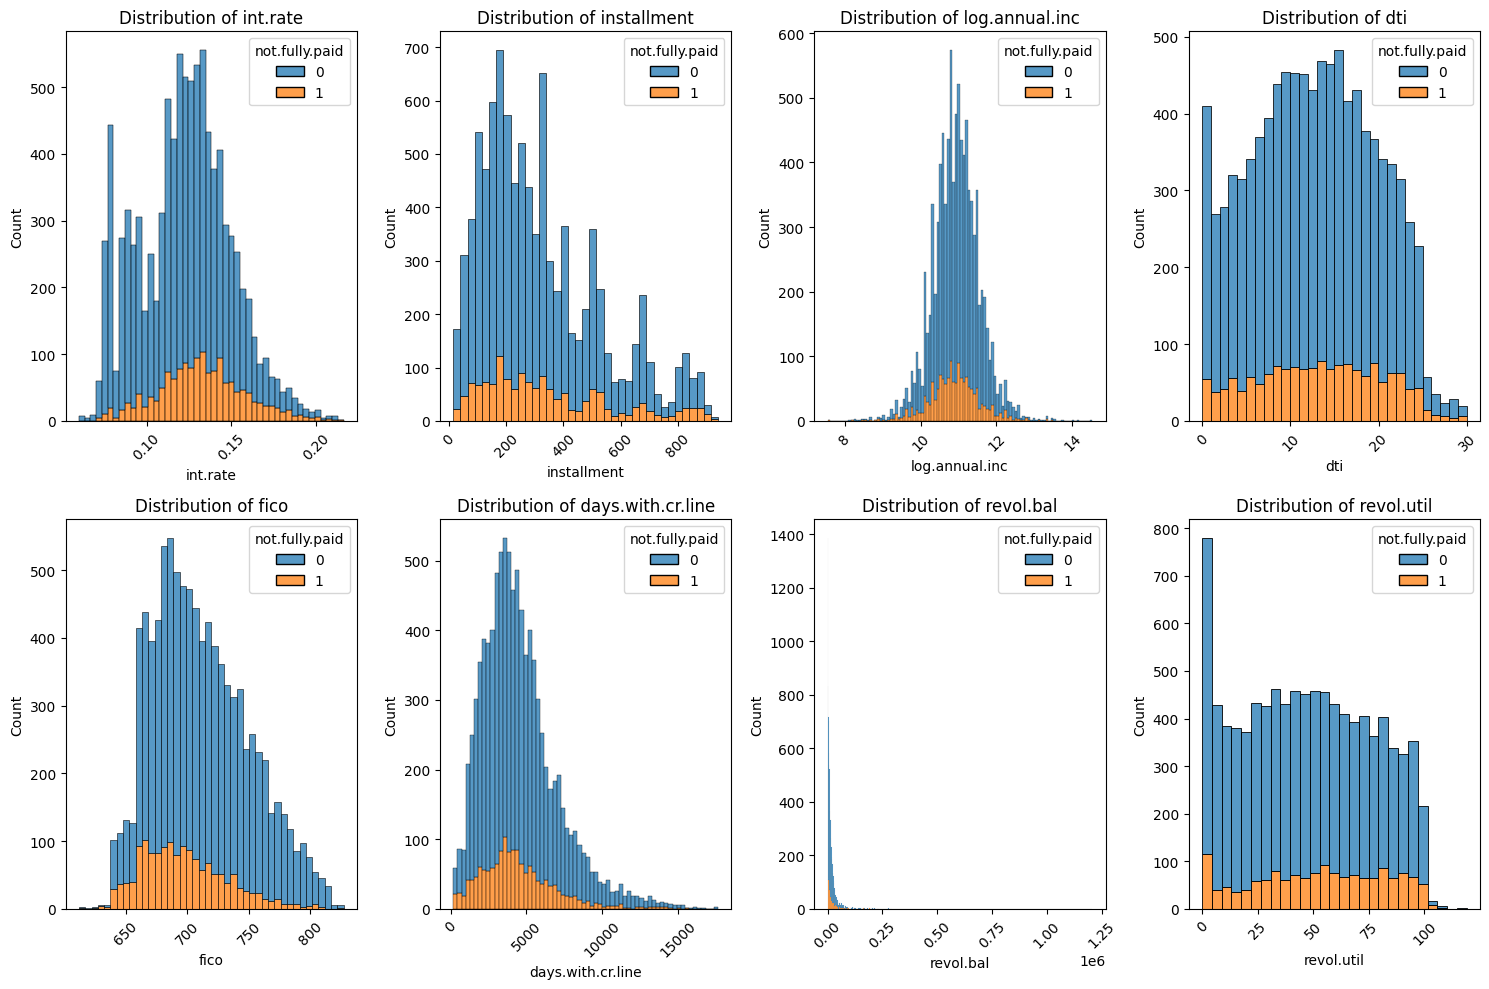

In [21]:
# Let's create histograms for numerical features
numerical_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 
                     'days.with.cr.line', 'revol.bal', 'revol.util']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data=loan_df, x=feature, hue='not.fully.paid', multiple="stack")
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

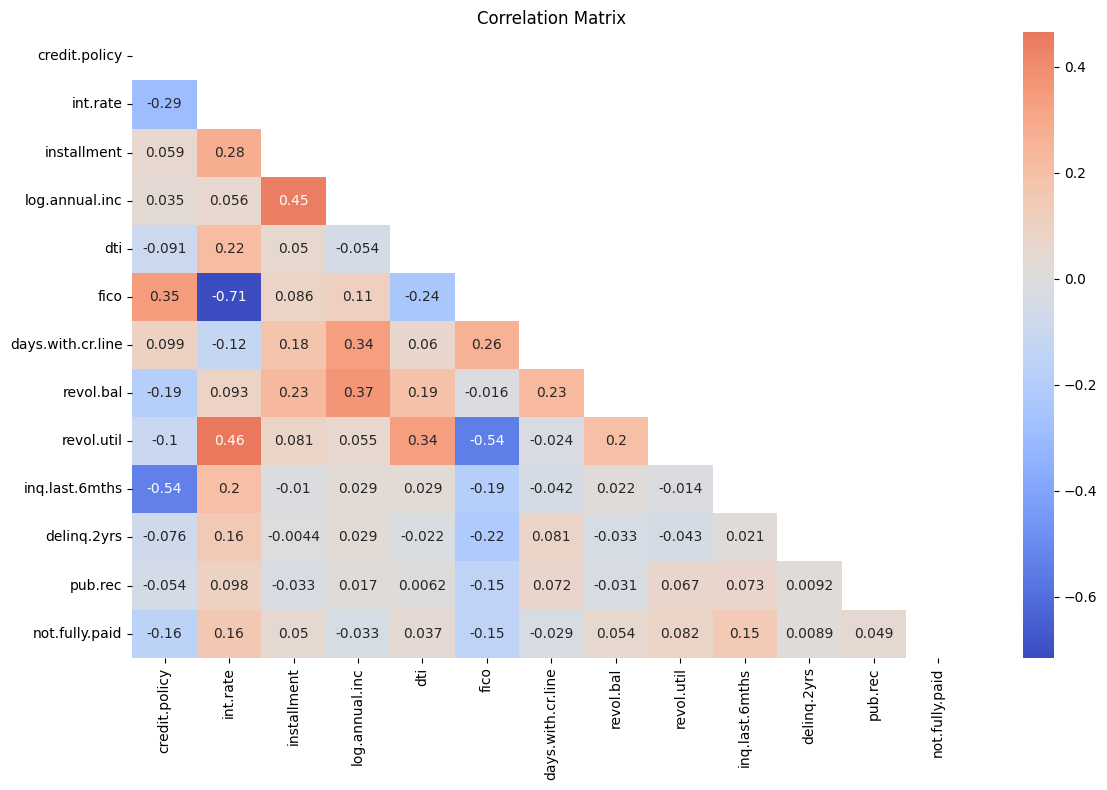

In [25]:
# Let's create correlation matrix
numerical_df = loan_df.drop('purpose', axis=1)
plt.figure(figsize=(12, 8))
correlation = numerical_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

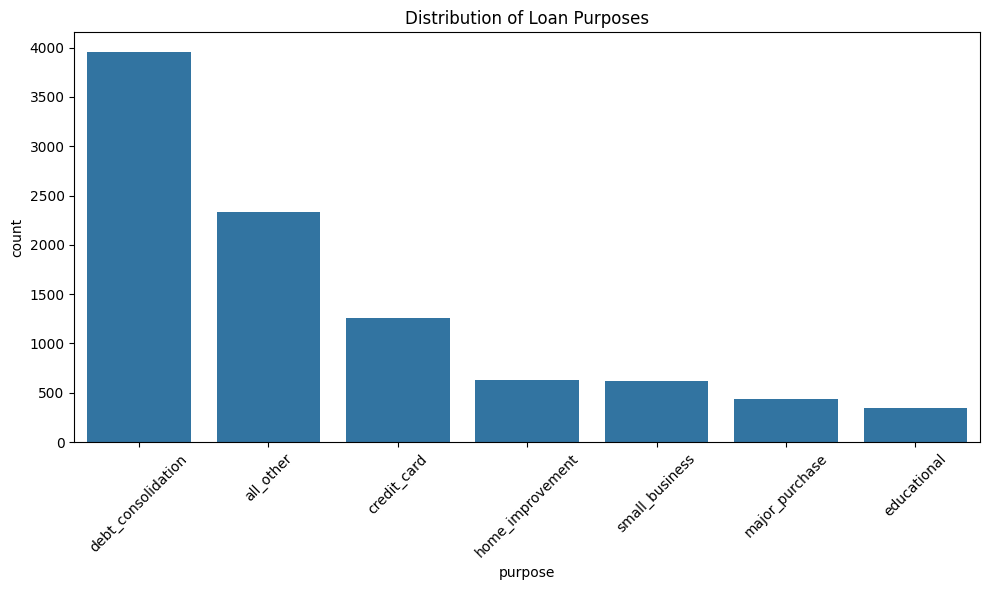


Default Rate by Purpose:
purpose
small_business        27.786753
educational           20.116618
home_improvement      17.011129
all_other             16.602317
debt_consolidation    15.238817
credit_card           11.568938
major_purchase        11.212815
Name: 1, dtype: float64


In [ ]:
# Let's analyze loan purposes
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_df, x='purpose', order=loan_df['purpose'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Loan Purposes')
plt.tight_layout()
plt.show()

# Calculate default rates by purpose
purpose_default = pd.crosstab(loan_df['purpose'], 
                             loan_df['not.fully.paid'], 
                             normalize='index') * 100
print("\nDefault Rate by Purpose:")
print(purpose_default[1].sort_values(ascending=False))

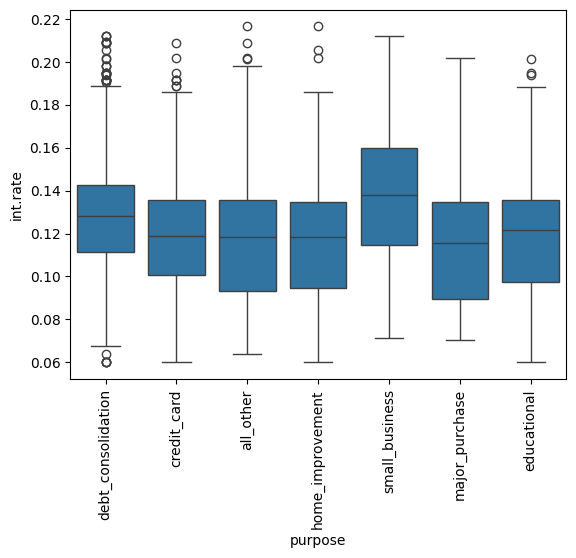

In [26]:
# Understanding the distribution of interest rates by loan purpose
sns.boxplot(x="purpose", y="int.rate", data=loan_df)
plt.xticks(rotation=90)
plt.show()

### Feature Engineering

Instead of preprocessing and cleaning the data, we will perform feature engineering to simplify the preprocessing task. 

In [27]:
# Let's perform feature engineering
loan_df["installment_to_income_ratio"] = (
    loan_df["installment"] / loan_df["log.annual.inc"]
)
loan_df["credit_history"] = (loan_df["delinq.2yrs"] + loan_df["pub.rec"]) / loan_df[
    "fico"
]

### Preprocessing and Balancing the Data

In [29]:
# Dropping unnecessary columns and converting the categorical variables to numerical ones.

from sklearn.preprocessing import LabelEncoder, StandardScaler

loan_df = loan_df.drop(['credit.policy', 'days.with.cr.line', 'purpose'], axis=1)


In [30]:
# Scaling the numerical features using Standard Scaler

scaler = StandardScaler()
numerical_cols = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec','credit_history','installment_to_income_ratio']
loan_df[numerical_cols] = scaler.fit_transform(loan_df[numerical_cols])

In [32]:
# Handling class imbalancing using imblearn’s oversampling method

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X = loan_df.drop('not.fully.paid', axis=1)
y = loan_df['not.fully.paid']

X_resampled, y_resampled = sm.fit_resample(X, y)

loan_df = pd.concat([X_resampled, y_resampled], axis=1)
loan_df['not.fully.paid'].value_counts()

not.fully.paid
0    8045
1    8045
Name: count, dtype: int64

As we can see, we have successfully balanced the class. 

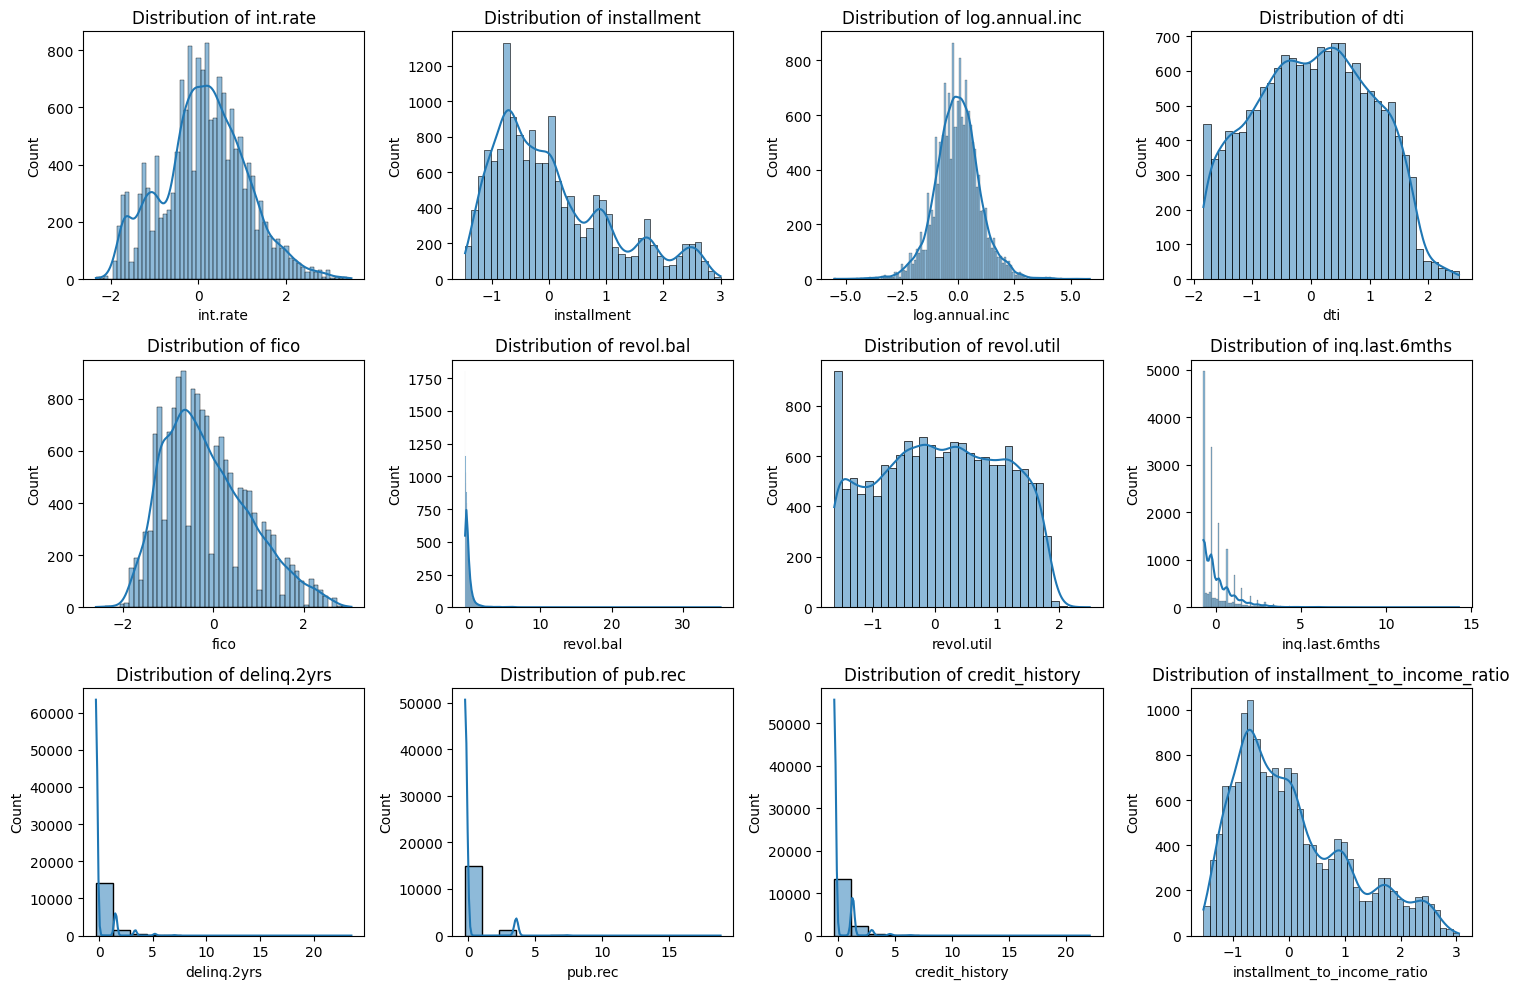

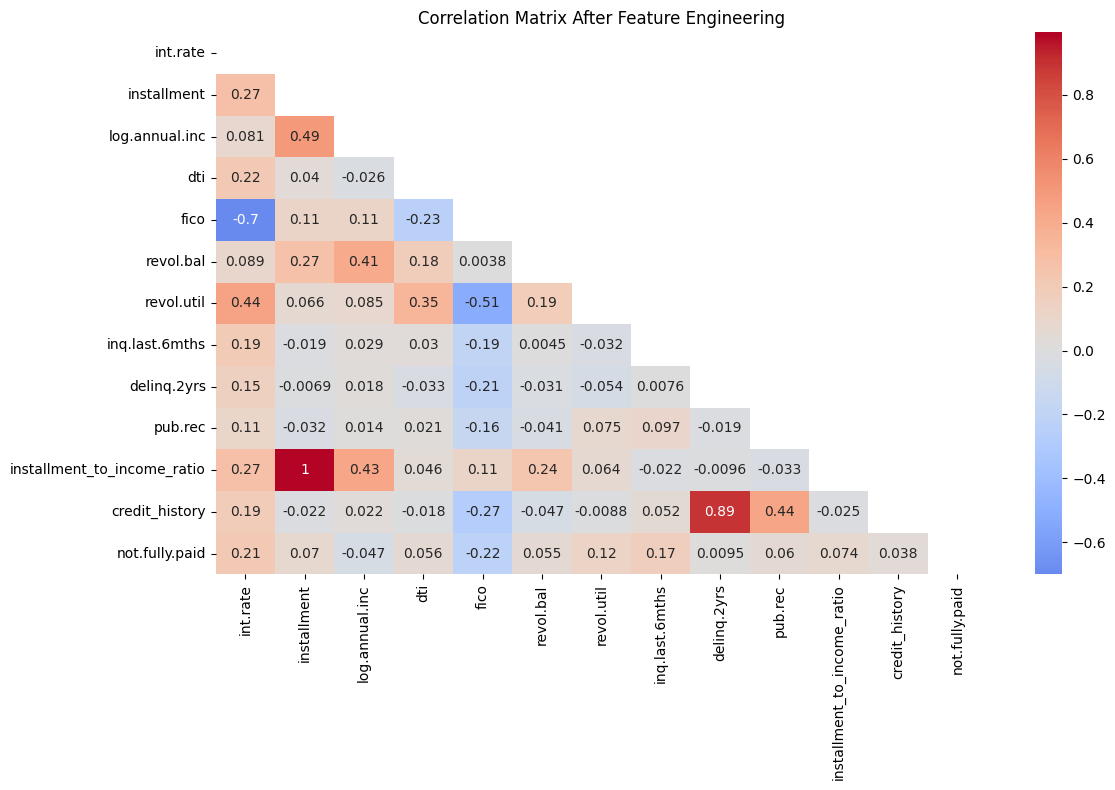

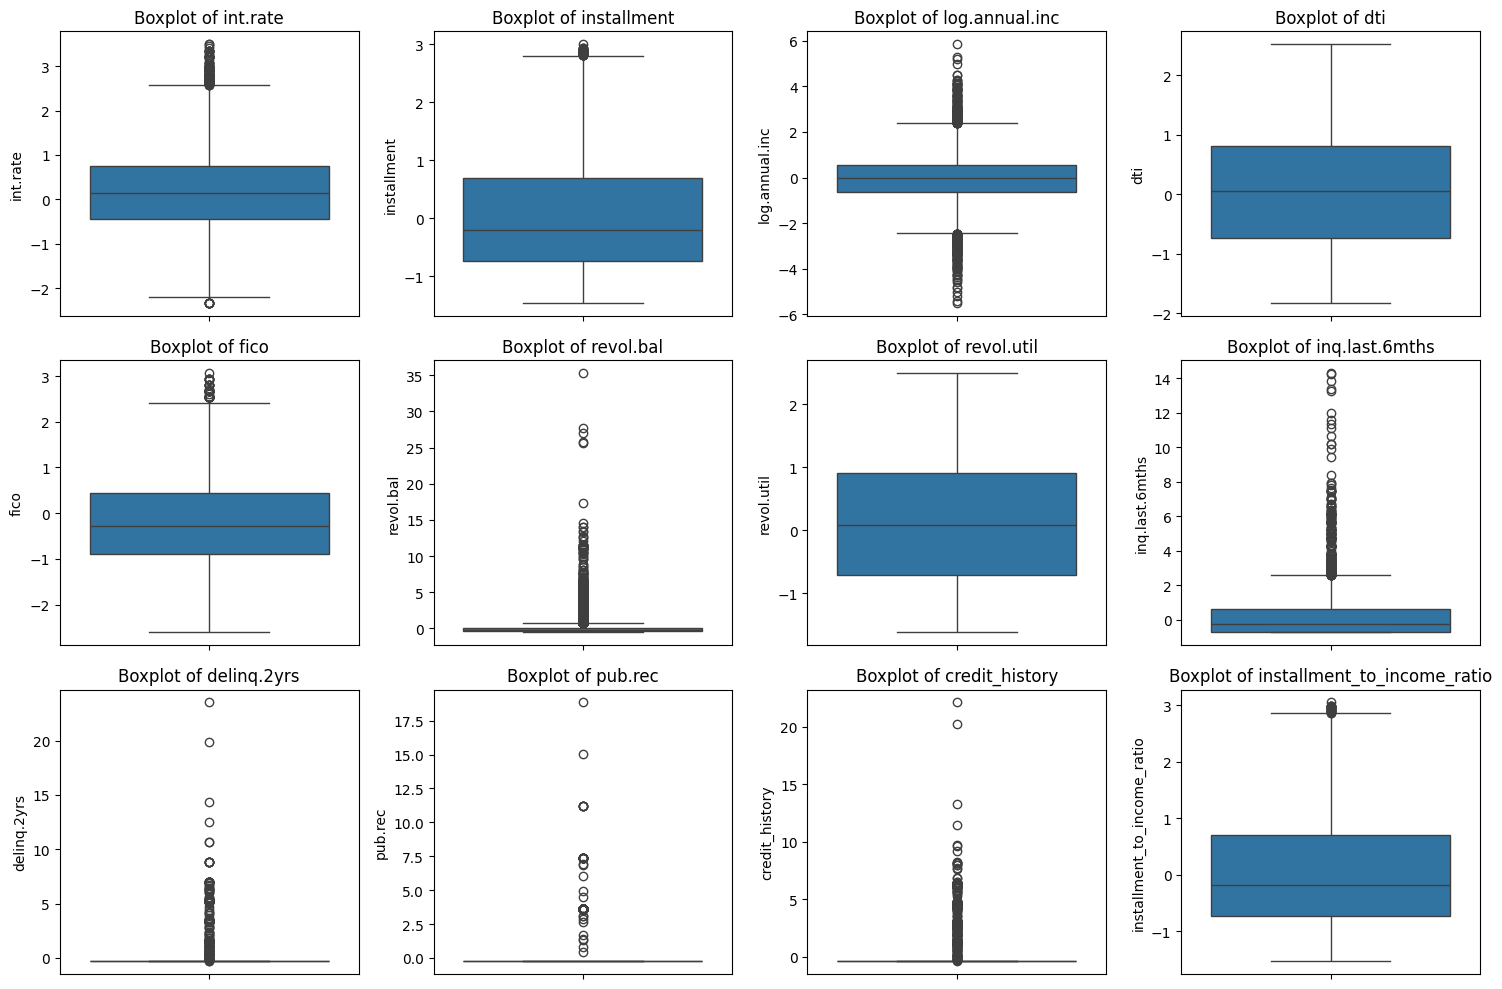

In [33]:
# Visualize the transformed features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data=loan_df, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Correlation matrix with new features
plt.figure(figsize=(12, 8))
correlation = loan_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix After Feature Engineering')
plt.tight_layout()
plt.show()

# Box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(data=loan_df, y=feature)
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

### Model Selection

In [38]:
# Split the dataset into training and testing sets
X = loan_df.drop('not.fully.paid', axis=1)
y = loan_df['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit and evaluate decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
print("Decision Tree Classifier Accuracy: {:.2f}%".format(dt_score*100))

# Fit and evaluate random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print("Random Forest Classifier Accuracy: {:.2f}%".format(rf_score*100))

# Fit and evaluate logistic regression classifier
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print("Logistic Regression Classifier Accuracy: {:.2f}%".format(lr_score*100))

# Fit and evaluate support vector machine classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
print("Support Vector Machine Classifier Accuracy: {:.2f}%".format(svm_score*100))

Decision Tree Classifier Accuracy: 81.17%
Random Forest Classifier Accuracy: 89.17%
Logistic Regression Classifier Accuracy: 61.28%
Support Vector Machine Classifier Accuracy: 66.54%


The Random Forest algorithm has significantly outperformed the other models.  

### Hyperparameter Tuning and Model Evaluation 

We will be selecting the better-performing model and performing the model evaluation. We have specified the use of accuracy, precision, recall, and F1 score as metrics and cross-validation to ensure the model stability.

In [40]:
# Let's define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the testing set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print("Random Forest Classifier Evaluation Results:")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))
print("Best hyperparameters:", best_params)

Random Forest Classifier Evaluation Results:
Accuracy: 89.10%
Precision: 89.29%
Recall: 88.54%
F1 Score: 88.92%
Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


We have a stable model with an 89.35 accuracy score. Both Precision and recall are similar. 

In [41]:
# In the end, we are saving the model using joblib. 
# This will allow us to load the model later.

import joblib
# Save the best model to disk
joblib.dump(best_model, 'loan_classifier.joblib')

['loan_classifier.joblib']

In [42]:
# Save the StandardScaler to disk
joblib.dump(scaler, 'std_scaler.joblib')

['std_scaler.joblib']